In [1]:
import numpy as np
import os
import rosbag
import matplotlib.pylab as plt
import copy
import sys
import tqdm
import time
import math
import bisect
from sklearn.cluster import KMeans

sys.path.append('home/koji/dvs/src')
from detector import get_event_list_from_bag, estimate_led_positions, estimate_led_positions_kmeans, get_estimated_pos_from_evidence_map

In [2]:
bagpath = '/home/koji/dvs/vlc/data/vlc_slow_100_100hz_00101101111001_00101101101110_noise.bag'
# bagpath = '/home/koji/dvs/vlc/data/vlc_slow_150hz_00101101111001.bag'
# bagpath = '/home/koji/dvs/vlc/data/led_500_700hz_light.bag'

event_list, event_time_list = get_event_list_from_bag(rosbag.Bag(bagpath), 0.5)

10868it [00:24, 440.56it/s]


In [3]:
fi = 100
estimated_pos_dict, evidence_map_dict = estimate_led_positions(
    event_list, 
    [fi], 
    0.5, 
    event_time_list=event_time_list, 
    n_tol=1, 
    sigma=30
)

In [4]:
fi = 100
estimated_pos_dict, evidence_map_dict = estimate_led_positions_kmeans(
    event_list, 
    fi, 
    n_led=2,
    t_at=0.5,
    event_time_list=event_time_list, 
    n_tol=1, 
    sigma=30
)

0.00041127439901096185


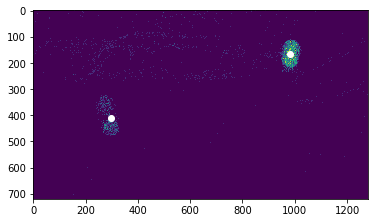

In [7]:
plt.imshow(np.array(evidence_map_dict[fi]).T)
plt.scatter(estimated_pos_dict[0][0], estimated_pos_dict[0][1], color='white')
plt.scatter(estimated_pos_dict[1][0], estimated_pos_dict[1][1], color='white')

print(np.max(evidence_map_dict[fi]))

In [62]:

def get_hist_and_time_debug(event_list, led_pos, t_begin=0.3, t_end=0.5, led_r = 40):
    x_min_cond = led_pos[0]-led_r < event_list[:, 0]
    x_max_cond = led_pos[0]+led_r > event_list[:, 0]
    y_min_cond = led_pos[1]-led_r < event_list[:, 1]
    y_max_cond = led_pos[1]+led_r > event_list[:, 1]
    event_list_freq = event_list[np.where(x_min_cond & x_max_cond & y_min_cond & y_max_cond)[0]].tolist()
    
    time_list = []
    polarity_list = []
    start_t = -1
    for event in event_list_freq:
        if start_t < 0:
            start_t = event[2]
        if event[2] - start_t < t_begin:
            continue
        time_list.append(event[2] - start_t)
        polarity_list.append(event[3])
        if event[2] - start_t > t_end:
            break
    time_list = np.array(time_list)
    polarity_list = np.array(polarity_list)
    return time_list, polarity_list

In [55]:

def get_hist_and_time(event_list, led_pos, t_begin=0.3, t_end=0.5, led_r = 40):
    x_min_cond = led_pos[0]-led_r < event_list[:, 0]
    x_max_cond = led_pos[0]+led_r > event_list[:, 0]
    y_min_cond = led_pos[1]-led_r < event_list[:, 1]
    y_max_cond = led_pos[1]+led_r > event_list[:, 1]
    event_list_freq = event_list[np.where(x_min_cond & x_max_cond & y_min_cond & y_max_cond)[0]].tolist()
    
    time_list = []
    polarity_list = []
    start_t = -1
    for event in event_list_freq:
        if start_t < 0:
            start_t = event[2]
        if event[2] - start_t < t_begin:
            continue
        time_list.append(event[2] - start_t)
        polarity_list.append(event[3])
        if event[2] - start_t > t_end:
            break
    time_list = np.array(time_list)
    polarity_list = np.array(polarity_list)
    
    # Very heuristic!!!!
    n_bins = (t_end - t_begin) * 5000
    
    plt.figure(figsize=(20, 4))
    hoge = plt.hist([time_list[polarity_list==1], time_list[polarity_list==0]], bins=1000, label=['positive', 'negative'])
    plt.xlabel('time [s]', fontsize=12)
    plt.xticks(fontsize=12)
    plt.ylabel('# of events', fontsize=12)
    plt.yticks(fontsize=12)
    plt.title('LED@{}Hz'.format(fi), fontsize=20)
    plt.legend()
    time_bins = hoge[1]
    hist_datas = hoge[0]
    return time_bins, hist_datas

In [56]:
def get_edges(hist_data, time_bins, thres=50):
    edges = []
    flag = False
    for time, val in zip(time_bins, hist_data):
        if val > thres and not flag:
            edges.append(time)
            flag = True
        elif val < thres and flag:
            flag = False
    return edges


In [57]:
def get_bits_from_edges(edges, freq):
    """
    edges: list of detected edge timestamps
    """
    tol_rate = 0.9
    bits = [True]
    cur_time = edges[0]
    cur_idx = 1
    while True:
        cur_time += 1.0/freq
        if edges[cur_idx] > cur_time - 0.5*tol_rate/freq and edges[cur_idx] < cur_time + 0.5*tol_rate/freq:
            bits.append(True)
            cur_idx += 1
        else:
            bits.append(False)
        if cur_idx >= len(edges) or cur_time > edges[-1]:
            break
    return bits

In [58]:
def get_sync_idx(bits, sync):
    n_sync = len(sync)
    n_bits = len(bits)
    sync_idx = []
    for i in range(n_bits - n_sync):
        is_sync = True
        for j in range(n_sync):
            is_sync = is_sync and (bits[i+j]*1==sync[j])
        if is_sync:
            sync_idx.append(i)
    return sync_idx

In [59]:
def encode_msg(bits, sync=[0, 0, 1, 0, 1, 1, 0], len_msg=6):
    sync_idx = get_sync_idx(bits, sync)
    n_sync = len(sync)
    for idx in sync_idx:
        msg = bits[idx+n_sync : idx+n_sync+len_msg]
        parity = bits[idx + n_sync + len_msg]
        if (sum(msg)+sum(sync))%2==parity:
            print('Detected the correct msg')
            return msg
        else:
            print('Error detected!!')

In [60]:
def encode_msg_old(bits, sync=[0, 0, 1, 0, 1, 1, 0], len_msg=6):
    current_sync_idx = 0
    sync_complete = False
    msg = []
    for bit in bits:
        if not sync_complete:
            if sync[current_sync_idx]==bit:
                current_sync_idx += 1
            else:
                current_sync_idx = 0
            if current_sync_idx == len(sync):
                sync_complete = True
        elif len(msg) == len_msg:
            if (sum(sync)+sum(msg))%2==bit:
                print('Detected the correct msg')
                return msg
            else:
                print('Error detected!!')
                sync_complete = False
                msg = []
        else:
            msg.append(bit)
    return []

In [63]:
time_list, polarity_list = get_hist_and_time_debug(np.array(event_list), pos, t_begin=0., t_end=0.5)

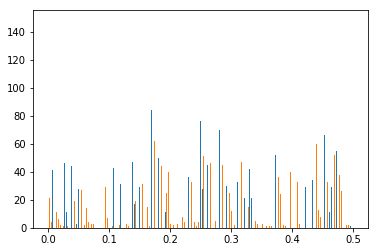

In [92]:
n_bins = 5000
hoge = plt.hist([time_list[polarity_list==1], time_list[polarity_list==0]], bins=n_bins, label=['positive', 'negative'])

In [93]:
range_hist = (np.min(time_list), np.max(time_list))
pos = np.histogram(time_list[polarity_list==1], bins=n_bins, range=range_hist)
neg = np.histogram(time_list[polarity_list==0], bins=n_bins, range=range_hist)
hoge[1] == pos[1]

array([ True,  True,  True, ...,  True,  True,  True])

In [95]:
hoge[0][0] == pos[0], hoge[0][1] == neg[0]

(array([ True,  True,  True, ...,  True,  True,  True]),
 array([ True,  True,  True, ...,  True,  True,  True]))

Detected the correct msg
pos:[981.0949464012251, 167.49157733537518], msg:[True, True, True, True, False, False]
Detected the correct msg
pos:[295.9845047039292, 408.9446596568899], msg:[True, True, False, True, True, True]


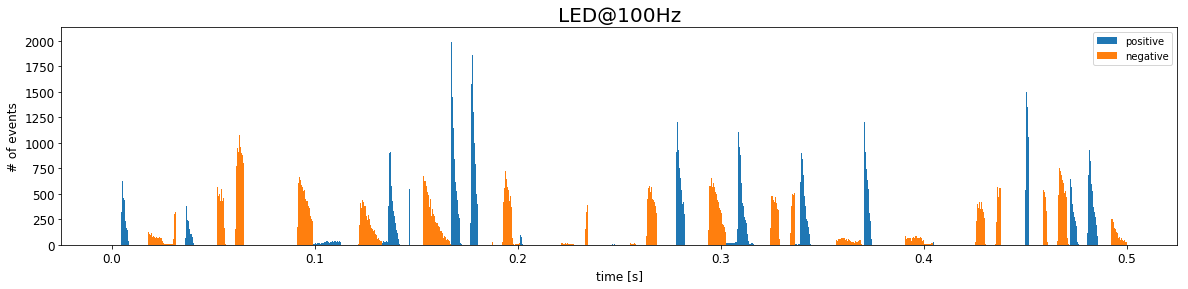

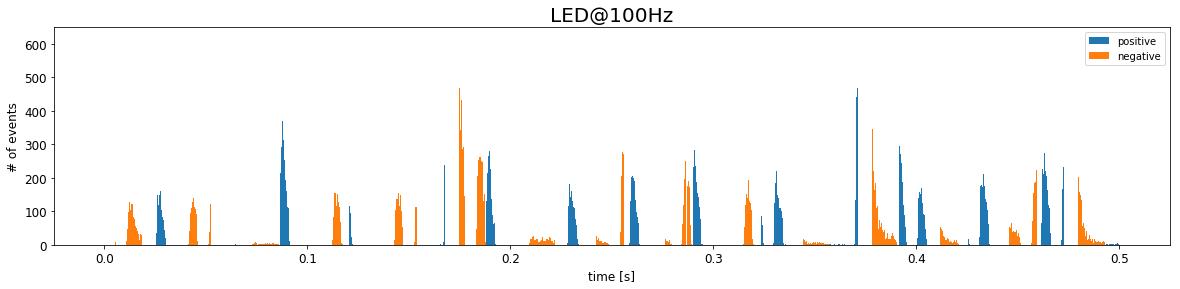

In [61]:
for pos in estimated_pos_dict.values():
    time_bins, hist_datas = get_hist_and_time(np.array(event_list), pos, t_begin=0., t_end=0.5)
    edges = get_edges(hist_datas[0], time_bins, thres=100)
    bits = get_bits_from_edges(edges, fi)
    msg = encode_msg(bits)
    print('pos:{0}, msg:{1}'.format(pos, msg))

# Miscellaneous

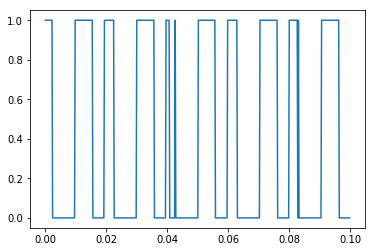

In [240]:
plt.plot(hoge[1][:-1], hoge[0]>250)

In [232]:
def get_event_time(event_list, led_pos):
    event_list_freq = []
    event_list_pos_freq = []
    event_list_neg_freq = []
    pos_freq = led_pos
    led_r = 20

    for event in tqdm.tqdm(event_list):
        if pos_freq[0]-led_r<event[0] and pos_freq[0]+led_r>event[0] and pos_freq[1]-led_r<event[1] and pos_freq[1]+led_r>event[1]:
            event_list_freq.append(event)
            if event[3]==1:
                event_list_pos_freq.append(event)
            else:
                event_list_neg_freq.append(event)
    count_hist = plt.hist(time_list,bins=500)
    plt.close()
    return event_list_pos_freq, event_list_neg_freq
#     plt.figure()
#     plt.plot(count_hist[1][:-1], count_hist[0]>250)

In [233]:
a, b = get_event_time(event_list, estimated_pos_dict[100])

100%|██████████| 517123/517123 [00:00<00:00, 680689.37it/s]


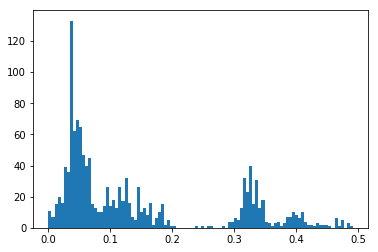

In [263]:
time_pos = []
for event in a:
    time_pos.append(event[2])
plt.hist(time_pos, bins=100)
plt.show()